Loaded CSV: exchange_rate.csv
Initial Data Shape: (7588, 2)


,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


After datetime conversion and index set: (7588, 1)


,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


Currency columns detected: ['Ex_rate']

Processing currency column: Ex_rate
Series length after preprocess: 7588


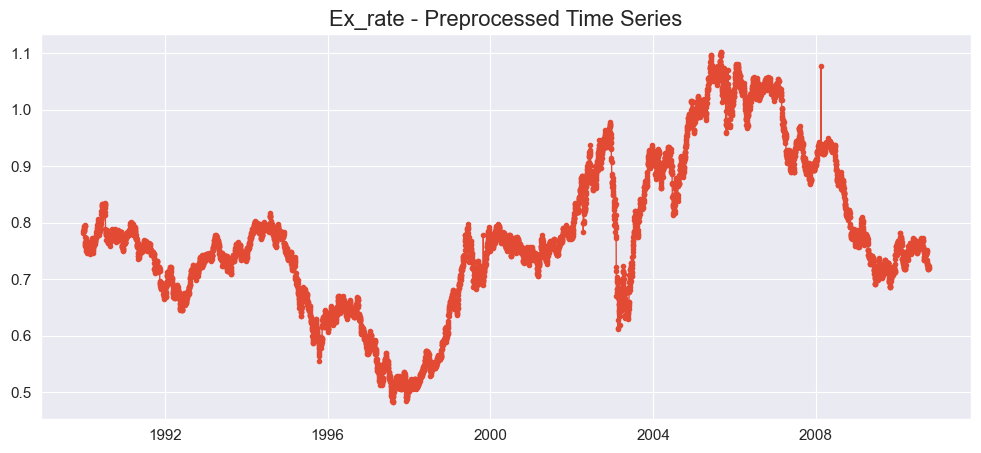

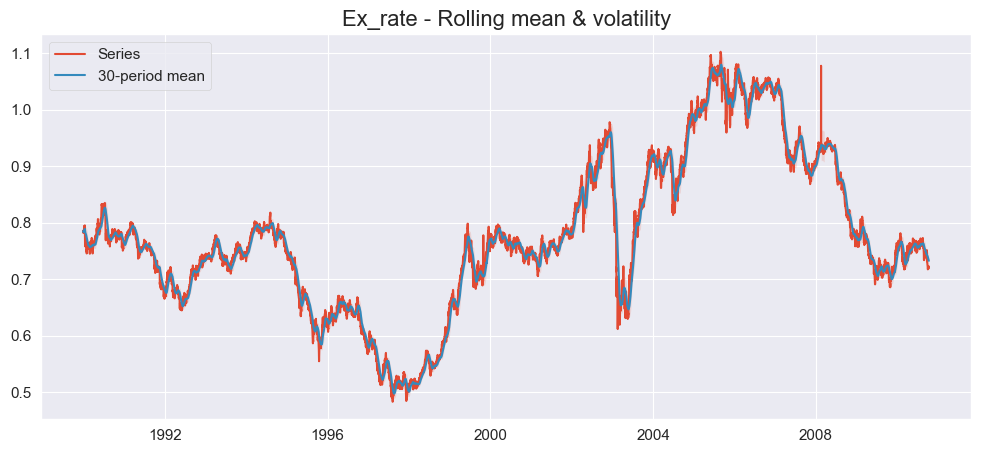

Train length = 6070, Test length = 1518
ADF Statistic: -0.9809, p-value: 0.7602
Series likely non-stationary (p>0.05). We'll consider d=1 in ARIMA searches.


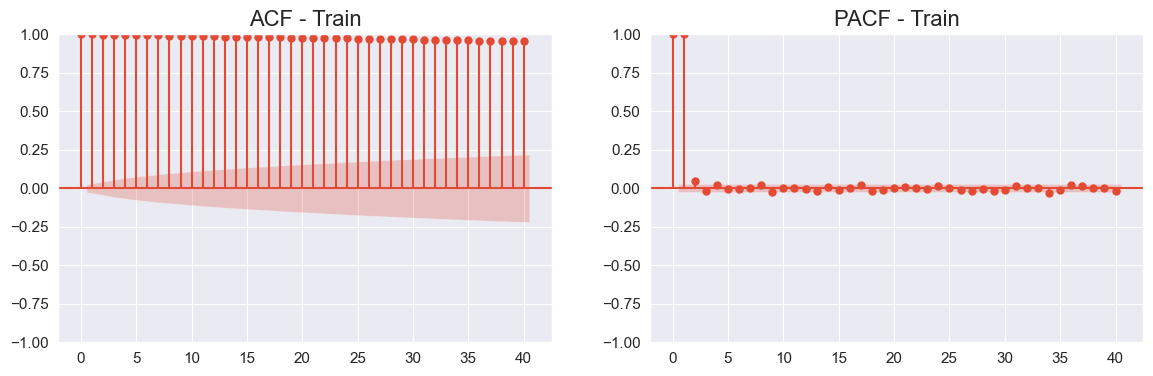

Grid searching ARIMA orders (p in 0..3, d in 0..1, q in 0..3) using AIC...
Selected ARIMA order: (2, 1, 3) AIC: -45436.21807102956
                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:                 ARIMA(2, 1, 3)   Log Likelihood               22724.109
Date:                Sun, 24 Aug 2025   AIC                         -45436.218
Time:                        22:04:54   BIC                         -45395.952
Sample:                    01-01-1990   HQIC                        -45422.243
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7246      0.094     -7.674      0.000      -0.910      -0.540


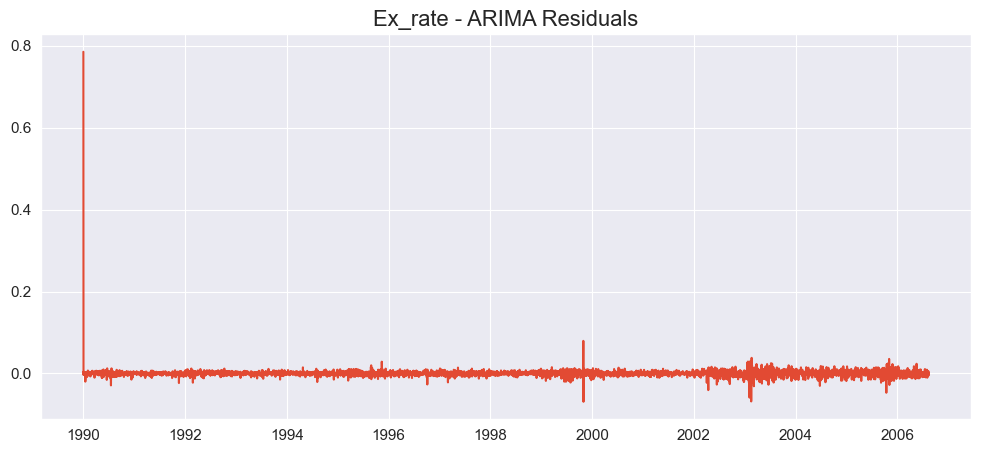

<Figure size 1200x500 with 0 Axes>

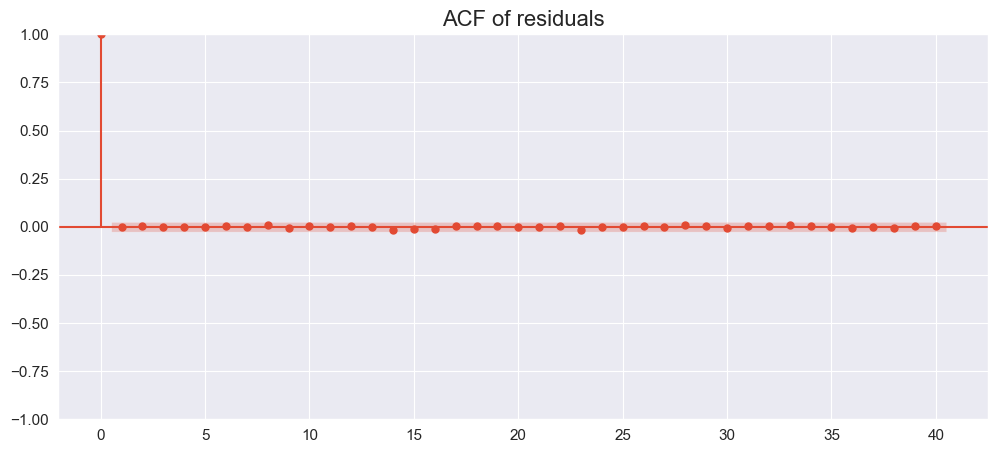

Ljung-Box (lag=10):


,lb_stat,lb_pvalue
10,1.022797,0.999809


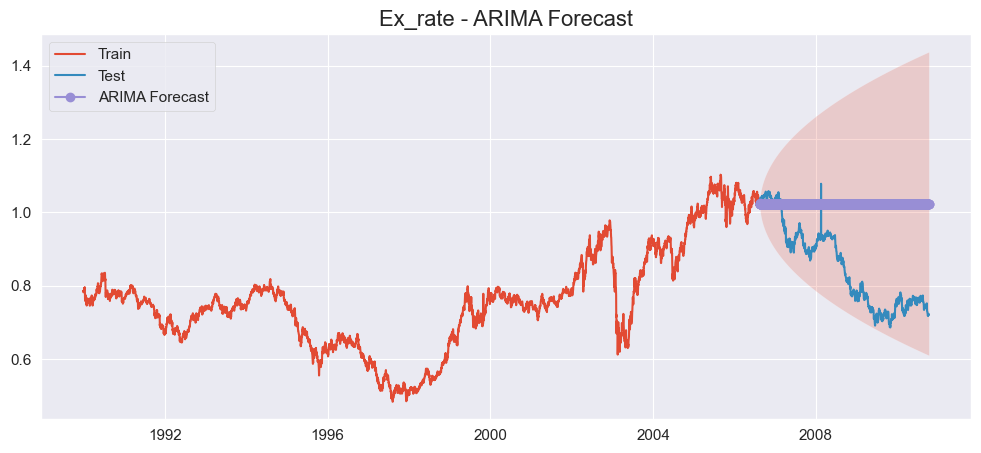

SES fitted.
Holt fitted.
Inferred seasonal_periods: 365
Holt-Winters additive fitted.
Holt-Winters multiplicative fitted.


,Model,ARIMA_order,MAE,RMSE,MAPE,AIC
1,SES,None,0.177638,0.205356,22.788856,-62659.342107
0,ARIMA,"(2, 1, 3)",0.177817,0.205557,22.811638,-45436.218071
2,Holt,None,0.190273,0.220085,24.412696,-62655.290061
3,HW_Add,None,0.214599,0.247430,27.504931,-62229.379867
4,HW_Mul,None,0.218562,0.251431,27.993636,-62270.219076


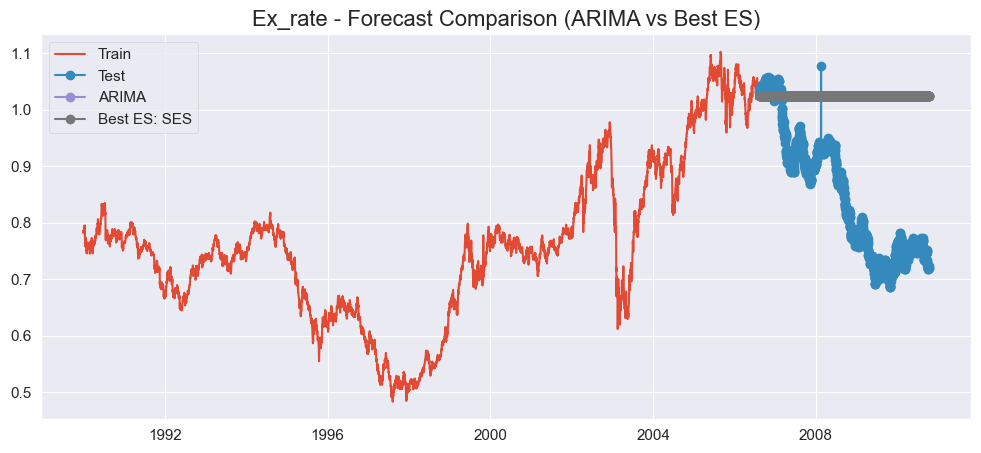

Saved metrics and ARIMA forecast for Ex_rate as CSVs.

Overall summary saved to 'forecast_summary_all_currencies.csv'.


,currency,best_model,MAE,RMSE,MAPE,AIC
0,Ex_rate,SES,0.177638,0.205356,22.788856,-62659.342107


In [5]:
# 0. Imports & plotting style (handle missing seaborn)
import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# plotting style: prefer seaborn if installed, else fallback
try:
    import seaborn as sns
    sns.set_style('darkgrid')
except Exception:
    plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

# Time series / stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# optional auto_arima
USE_PMDARIMA = False
try:
    from pmdarima import auto_arima
    USE_PMDARIMA = True
except Exception:
    USE_PMDARIMA = False

# Utility functions
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0: 
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def ensure_datetime_index(df, date_col):
    """Convert date column to datetime (dayfirst True to support dd-mm-yyyy), set as index, drop NaN index rows."""
    df = df.copy()
    # try multiple parse strategies
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    # drop rows where date parsing failed
    if df[date_col].isna().any():
        nbad = df[date_col].isna().sum()
        print(f"Warning: {nbad} rows had invalid dates and will be dropped.")
        df = df.dropna(subset=[date_col]).reset_index(drop=True)
    df = df.sort_values(by=date_col).reset_index(drop=True)
    df = df.set_index(date_col)
    # drop rows with NaN index if any (defensive)
    df = df[~df.index.isna()]
    return df

def infer_seasonal_period(index):
    """Try to infer a sensible seasonal_period for Holt-Winters."""
    freq = pd.infer_freq(index)
    if freq is not None:
        if freq.startswith('M'):
            return 12
        if freq.startswith('Q'):
            return 4
        if freq.startswith('W'):
            return 52
        if freq.startswith('D'):
            # if daily, try to detect weekly or yearly; use 7 or 365 depending on span
            span_days = (index.max() - index.min()).days
            if span_days >= 365 * 2:
                return 365
            else:
                return 7
        if freq.startswith('H'):
            return 24
    # if freq not inferred, fallback: compute median delta and decide.
    deltas = (index.to_series().diff().dropna().map(lambda x: x.days if hasattr(x, 'days') else np.nan))
    if len(deltas)>0:
        median_days = int(deltas.median())
        if median_days >= 28 and median_days <= 31:
            return 12
        if median_days == 7:
            return 52
        if median_days == 1:
            # daily data
            total_days = (index.max() - index.min()).days
            if total_days >= 365*2:
                return 365
            return 7
    # final fallback
    return 12

# -------------------------------
# 1) LOAD DATA (CSV or Excel)
# -------------------------------

CSV_FILE = "exchange_rate.csv"  
EXCEL_FILE = "exchange_rate.xlsx"

if Path(CSV_FILE).exists():
    df_raw = pd.read_csv(CSV_FILE)
    print(f"Loaded CSV: {CSV_FILE}")
elif Path(EXCEL_FILE).exists():
    df_raw = pd.read_excel(EXCEL_FILE)
    print(f"Loaded Excel: {EXCEL_FILE}")
else:
    raise FileNotFoundError("No 'exchange_rate.csv' or 'exchange_rate.xlsx' found in working directory.")

print("Initial Data Shape:", df_raw.shape)
display(df_raw.head())

# -------------------------------
# 2) PREPROCESS: ensure datetime index and select column(s)
# -------------------------------
# We assume first column is date. If multiple currency columns exist, we'll process them automatically.
date_col = df_raw.columns[0]
currency_cols = list(df_raw.columns[1:])   # all other columns are candidate currency series

if len(currency_cols) == 0:
    raise ValueError("No currency columns found (expected at least one column besides the date column).")

# convert and set index
df = ensure_datetime_index(df_raw, date_col)
print("After datetime conversion and index set:", df.shape)
display(df.head())

# If there are multiple currency columns, keep them; otherwise, single series
print("Currency columns detected:", currency_cols)

# -------------------------------
# 3) Iterate through each currency column and run full workflow
# -------------------------------
output_results = []  # store metric summaries for each currency

for col in currency_cols:
    print("\n" + "="*80)
    print(f"Processing currency column: {col}")
    series = df[col].copy().astype(float)  # ensure numeric
    
    # Drop rows with missing values in series index if they exist for interpolation to work
    # Keep the index intact (DatetimeIndex)
    # If entire series is NaN -> skip
    if series.dropna().empty:
        print(f"Column {col} has no valid numeric data after dropping NaNs. Skipping.")
        continue

    # Interpolation and missing handling:
    # Ensure index has no NaNs (we already cleaned). Now interpolate using time-based method.
    try:
        series = series.interpolate(method='time', limit_direction='both')
    except NotImplementedError:
        # fallback to linear interpolation if time interpolation fails
        series = series.interpolate(method='linear', limit_direction='both')

    # Simple outlier cap via IQR (winsorize)
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    series = series.clip(lower=lower, upper=upper)

    # Final dropna if any
    series = series.dropna()
    print(f"Series length after preprocess: {len(series)}")

    # Plot series & rolling stats
    plt.figure()
    plt.plot(series, marker='.', linewidth=1)
    plt.title(f'{col} - Preprocessed Time Series')
    plt.show()

    # Rolling mean/std
    roll_mean = series.rolling(window=30, min_periods=1).mean()
    roll_std = series.rolling(window=30, min_periods=1).std()
    plt.figure()
    plt.plot(series, label='Series')
    plt.plot(roll_mean, label='30-period mean')
    plt.fill_between(series.index, roll_mean - roll_std, roll_mean + roll_std, alpha=0.15)
    plt.legend()
    plt.title(f'{col} - Rolling mean & volatility')
    plt.show()

    # -------------------------------
    # Train-test split (last 20% as test)
    # -------------------------------
    n = len(series)
    test_size = max(1, int(np.ceil(0.2 * n)))
    train = series.iloc[:-test_size]
    test = series.iloc[-test_size:]
    print(f"Train length = {len(train)}, Test length = {len(test)}")

    # -------------------------------
    # Stationarity test (ADF)
    # -------------------------------
    adf_res = adfuller(train)
    print(f"ADF Statistic: {adf_res[0]:.4f}, p-value: {adf_res[1]:.4f}")
    d_required = 0
    if adf_res[1] > 0.05:
        print("Series likely non-stationary (p>0.05). We'll consider d=1 in ARIMA searches.")
        d_required = 1

    # Plot ACF/PACF
    fig, axes = plt.subplots(1,2, figsize=(14,4))
    plot_acf(train, lags=40, ax=axes[0])
    plot_pacf(train, lags=40, ax=axes[1], method='ywm')
    axes[0].set_title('ACF - Train')
    axes[1].set_title('PACF - Train')
    plt.show()

    # -------------------------------
    # ARIMA: auto selection if possible, else grid search (p,d,q)
    # -------------------------------
    arima_model = None
    arima_order = None
    if USE_PMDARIMA:
        print("Using pmdarima.auto_arima to select order (this may take some time)...")
        try:
            auto = auto_arima(train, start_p=0, start_q=0, max_p=4, max_q=4,
                              d=None, seasonal=False, stepwise=True, trace=True,
                              error_action='ignore', suppress_warnings=True)
            arima_order = auto.order
            print("auto_arima selected order:", arima_order)
            # convert pmdarima model to statsmodels ARIMA by refitting
            arima_model = ARIMA(train, order=arima_order).fit()
        except Exception as e:
            print("auto_arima failed:", e)
            USE_PMDARIMA = False  # fallback to grid search

    if arima_model is None:
        print("Grid searching ARIMA orders (p in 0..3, d in 0..1, q in 0..3) using AIC...")
        best_aic = np.inf
        best_order = None
        for p in range(0,4):
            for d in ([0,1] if d_required==1 else [0,1]):
                for q in range(0,4):
                    try:
                        tmp = ARIMA(train, order=(p,d,q)).fit()
                        if tmp.aic < best_aic:
                            best_aic = tmp.aic
                            best_order = (p,d,q)
                            arima_model = tmp
                    except Exception:
                        continue
        arima_order = best_order
        print("Selected ARIMA order:", arima_order, "AIC:", best_aic)

    # ARIMA summary & residuals
    print(arima_model.summary())

    resid = arima_model.resid.dropna()
    plt.figure()
    plt.plot(resid)
    plt.title(f'{col} - ARIMA Residuals')
    plt.show()

    # ACF of residuals
    plt.figure()
    plot_acf(resid, lags=40)
    plt.title('ACF of residuals')
    plt.show()

    # Ljung-Box
    try:
        lb = acorr_ljungbox(resid, lags=[10], return_df=True)
        print("Ljung-Box (lag=10):")
        display(lb)
    except Exception as e:
        print("Ljung-Box test failed:", e)

    # Forecast with ARIMA
    steps = len(test)
    arima_pred = arima_model.get_forecast(steps=steps)
    arima_forecast = pd.Series(arima_pred.predicted_mean, index=test.index)
    arima_ci = arima_pred.conf_int()

    # Plot ARIMA vs actual
    plt.figure()
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', marker='o')
    plt.fill_between(arima_forecast.index, arima_ci.iloc[:,0], arima_ci.iloc[:,1], alpha=0.2)
    plt.legend()
    plt.title(f'{col} - ARIMA Forecast')
    plt.show()

    # -------------------------------
    # Exponential Smoothing (SES, Holt, Holt-Winters)
    # -------------------------------
    es_results = {}

    # SES
    try:
        ses = SimpleExpSmoothing(train).fit(optimized=True)
        ses_fore = ses.forecast(steps)
        es_results['SES'] = (ses, pd.Series(ses_fore, index=test.index))
        print("SES fitted.")
    except Exception as e:
        print("SES failed:", e)

    # Holt's Linear
    try:
        holt = ExponentialSmoothing(train, trend='add', seasonal=None, initialization_method="estimated").fit(optimized=True)
        holt_fore = holt.forecast(steps)
        es_results['Holt'] = (holt, pd.Series(holt_fore, index=test.index))
        print("Holt fitted.")
    except Exception as e:
        print("Holt failed:", e)

    # Holt-Winters additive/multiplicative (try both if possible)
    seasonal_periods = infer_seasonal_period(series.index)
    print("Inferred seasonal_periods:", seasonal_periods)

    try:
        hw_add = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods, initialization_method="estimated").fit(optimized=True)
        hw_add_fore = hw_add.forecast(steps)
        es_results['HW_Add'] = (hw_add, pd.Series(hw_add_fore, index=test.index))
        print("Holt-Winters additive fitted.")
    except Exception as e:
        print("Holt-Winters additive failed:", e)

    try:
        hw_mul = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=seasonal_periods, initialization_method="estimated").fit(optimized=True)
        hw_mul_fore = hw_mul.forecast(steps)
        es_results['HW_Mul'] = (hw_mul, pd.Series(hw_mul_fore, index=test.index))
        print("Holt-Winters multiplicative fitted.")
    except Exception as e:
        print("Holt-Winters multiplicative failed:", e)

    # -------------------------------
    # Evaluate models: compute MAE, RMSE, MAPE for each candidate (including ARIMA)
    # -------------------------------
    metrics = []
    # ARIMA metrics
    a_mae = mean_absolute_error(test, arima_forecast)
    a_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
    a_mape = mape(test.values, arima_forecast.values)
    metrics.append(('ARIMA', arima_order, a_mae, a_rmse, a_mape, getattr(arima_model,'aic', np.nan)))

    # ES metrics
    for name, (model_obj, pred_series) in es_results.items():
        try:
            mae_ = mean_absolute_error(test, pred_series)
            rmse_ = np.sqrt(mean_squared_error(test, pred_series))
            mape_ = mape(test.values, pred_series.values)
            aic_ = getattr(model_obj, 'aic', np.nan)
            metrics.append((name, None, mae_, rmse_, mape_, aic_))
        except Exception as e:
            print(f"Could not compute metrics for {name}:", e)

    metrics_df = pd.DataFrame(metrics, columns=['Model','ARIMA_order','MAE','RMSE','MAPE','AIC']).sort_values('RMSE')
    display(metrics_df)

    # Plot best ES vs ARIMA
    plt.figure()
    plt.plot(train, label='Train')
    plt.plot(test, label='Test', marker='o')

    # ARIMA
    plt.plot(arima_forecast.index, arima_forecast, label='ARIMA', marker='o')

    # best ES by RMSE (if any)
    es_candidates = [r for r in metrics if r[0] != 'ARIMA']
    if es_candidates:
        best_es = sorted(es_candidates, key=lambda x: x[3])[0]  # by RMSE
        best_name = best_es[0]
        best_pred = es_results[best_name][1]
        plt.plot(best_pred.index, best_pred, label=f'Best ES: {best_name}', marker='o')

    plt.legend()
    plt.title(f'{col} - Forecast Comparison (ARIMA vs Best ES)')
    plt.show()

    # Save metrics and basic outputs for this currency
    out = {
        'currency': col,
        'metrics_df': metrics_df,
        'arima_forecast': arima_forecast,
        'arima_ci': arima_ci,
        'es_results': es_results
    }
    output_results.append(out)

    # Optionally save figure files
    safe_col = "".join(c for c in col if c.isalnum() or c in (' ','_')).rstrip()
    metrics_df.to_csv(f'forecast_metrics_{safe_col}.csv', index=False)
    arima_forecast.to_csv(f'arima_forecast_{safe_col}.csv')
    print(f"Saved metrics and ARIMA forecast for {col} as CSVs.")

# -------------------------------
# 4) Consolidate & Save Summary
# -------------------------------
summary_rows = []
for r in output_results:
    metrics_df = r['metrics_df']
    best_row = metrics_df.iloc[0].to_dict()  # best by RMSE after sorting
    summary_rows.append({
        'currency': r['currency'],
        'best_model': best_row['Model'],
        'MAE': best_row['MAE'],
        'RMSE': best_row['RMSE'],
        'MAPE': best_row['MAPE'],
        'AIC': best_row['AIC']
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv('forecast_summary_all_currencies.csv', index=False)
print("\nOverall summary saved to 'forecast_summary_all_currencies.csv'.")
display(summary_df)
